In [1]:
import cv2 
import numpy as np
import os
import platform

if platform.system() =="Windows" or platform.system() =="linux": # MacOS: posix
    import matplotlib.pylab as plt
    
import math 
from function import Region
from function import Contour
from function import Image
import dis
import numba 
import time

def showC(img):
    rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(rgb,cmap="gray")
    
def show(img):
    plt.imshow(img,cmap="gray")
    
def timer(func):
    def wrapper( *args, **kwargs):
        t0 = time.time()
        result = func(*args, **kwargs)
        t1 =time.time()
        print(f'Function {func.__name__} took: {round((t1-t0)*1000, 6)} (ms)')
        return result
    return wrapper 

e:\Class_XLA_02\Ipynb\function.py:456: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(fastmath = True)
e:\Class_XLA_02\Ipynb\function.py:568: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(parallel =True)
e:\Class_XLA_02\Ipynb\function.py:588: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorat

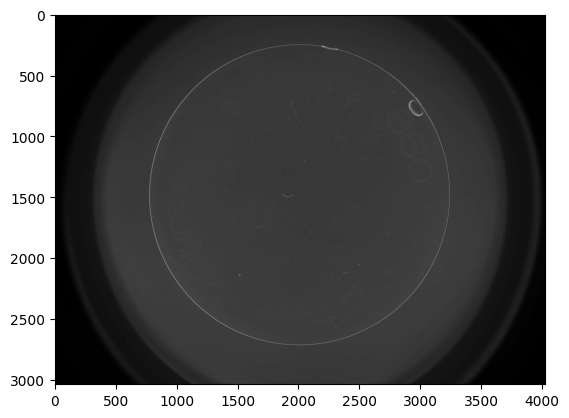

In [385]:

img = cv2.imread("images/Process Error_1106 16265319 - DF.bmp")
img_copy = img.copy()
gray = cv2.imread("images/Process Error_1106 16265319 - DF.bmp",0 )
show(gray)

## Teaching (Create ROI when teaching)

### Create Mask

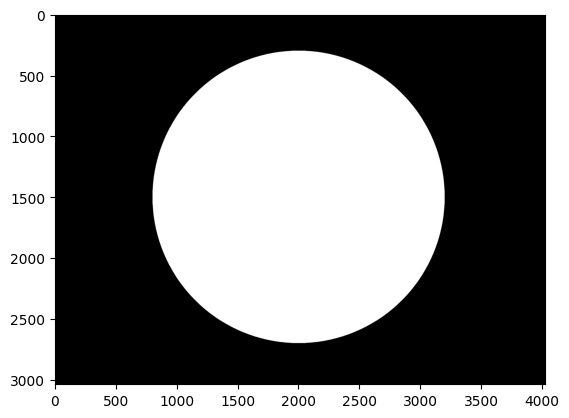

In [3]:
black_mask = np.zeros((gray.shape[0], gray.shape[1]),dtype = np.uint8 )

cv2.circle(black_mask, (2000,1500),200, (255,255,255),2000)
show(black_mask)

### Threshold Range -> Find Len Location

Function ThresholdRange took: 9.003401 (ms)
index:1
Function SelectShapeStd took: 73.9334 (ms)


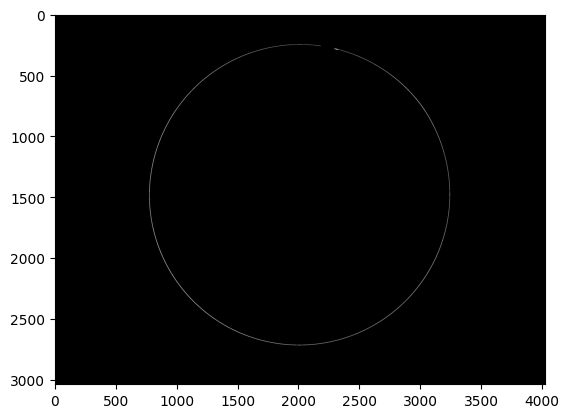

In [390]:
@timer
def ThresholdRange(gray, t1, t2):
        """
            t1 < t2
        """
        _, threshold1 = cv2.threshold(gray, t1, 255, cv2.THRESH_BINARY)
        _, threshold2= cv2.threshold(gray, t2, 255, cv2.THRESH_BINARY)
        
        threshold = cv2.bitwise_xor(threshold2,threshold1, mask= None)
        return threshold
    
threshhold = ThresholdRange(gray, 110 ,255)

len_location = Region.SelectShapeStd(threshhold)
show(len_location)

### Region to Contour and ConvexHull

In [5]:
contours, _ =cv2.findContours(len_location,  cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
len(contours[0])
moment = cv2.moments(contours[0])
center_x = int(moment["m10"] / moment["m00"])
center_y = int(moment["m01"] / moment["m00"])
print(center_x, center_y)

1896 1580


Function DrawContourMask took: 1.9991 (ms)


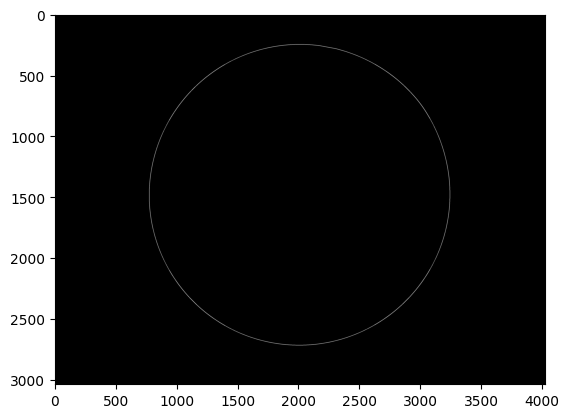

In [391]:
def ConvexHull(contour):
    len(contour)
    if len(contour) ==0 :
        return []
    # ConvextHull 
    hull_list = []
    for cnt in contour:
        hull_list.append (cv2.convexHull(cnt[1:]))
        
    return  hull_list
    
hull  = ConvexHull(contours)
mask  = Region.DrawContourMask((gray.shape[:2]),hull, thickness = 2)
show(mask)

### Line and Contours Intersection Foundation

* Line (A,B,C)
* Contours: Array of Point
* Result:$$-> Return \space Point \space in \space Intersection \space Collection \space point$$ 

In [7]:
@timer
@numba.jit(parallel = True)
def intersec_line_contour(line, contours):
    point_intersec = []
    
    return point_intersec

C:\Users\manmu\AppData\Local\Temp\ipykernel_6012\1388062036.py:2: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(parallel = True)


### Find Intersection Line and Contours 1

In [381]:
def rotate_point(P, O, alpha):
    # Degree -> Radian
    alpha_rad = math.radians(alpha)

    # Cordinate P 
    x = P[0] - O[0]
    y = P[1] - O[1]
    x_prime = x * math.cos(alpha_rad) - y * math.sin(alpha_rad)
    y_prime = x * math.sin(alpha_rad) + y * math.cos(alpha_rad)

    # Cordinate in O
    x_prime += O[0]
    y_prime += O[1]

    return int(x_prime), int(y_prime)

@timer
def FindMissingEdge(threshold, center):
    R = 20
    P =(int(center[0]),R)
    step = 0.5 # Define Dregree
    # 12H -> 
    num_step = int(360 / step)
    result = np.zeros(threshold.shape[:2], dtype = np.uint8)
    for i in range(1,num_step+1): 
        alpha = step * i
        x_prime , y_prime = rotate_point(P,center, alpha )
        P = (x_prime , y_prime)
        
        mask = np.zeros(threshold.shape[:2], dtype = np.uint8)
        cv2.line(mask, (int(center[0]), int(center[1])), (x_prime,y_prime), (255,255,255),5)
        
        diff = cv2.bitwise_and(mask,threshold, mask = None)
        if (np.any(diff == 255)) == False:
            result = cv2.bitwise_or(result,mask)
            
    return result

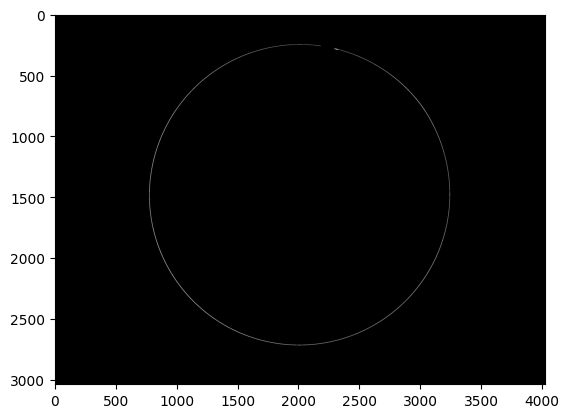

In [382]:
show(len_location)

In [383]:
result = FindMissingEdge(len_location,(center_x, center_y))

Function FindMissingEdge took: 9999.998331 (ms)


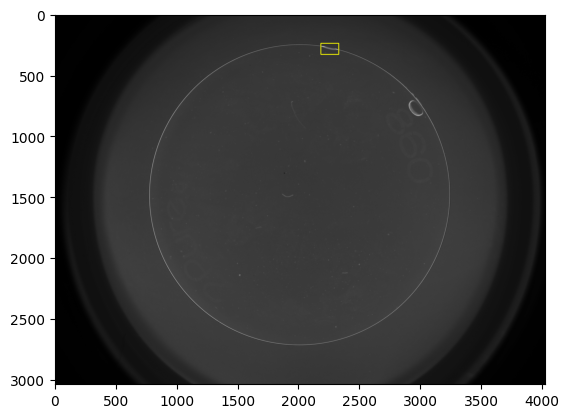

In [384]:
show(result)
diff = cv2.bitwise_and(mask, result, mask = None)
x,y,w,h =  cv2.boundingRect(diff)
offset = 25
img_copy = img.copy()
cv2.rectangle(img_copy,(x-offset,y - offset), (x+w+ 2*offset, y+h +2*offset), (255,255,0), 6)
show(img_copy)

### Find intersection Line and Contours

In [30]:
# Tạo hai mảng hình ảnh đơn giản
array1 = np.array([[0, 0, 0],
                   [0, 255, 0],
                   [0, 0, 0]])

array2 = np.array([[0, 255, 0],
                   [0, 3, 0],
                   [0, 255, 0]])

# Tìm vị trí và giá trị pixel chung
common_positions = np.where((array1 == 255) & (array2 == 255))
print(len(common_positions[0]))

0


In [402]:
def rotate_point(P, O, alpha):
    """
        Input: P point 
        Ouput: P': kết quả của phép xoay tâm 0, góc alpha -> (int(x_prime), int(y_prime))
    
    """
    # Degree -> Radian
    alpha_rad = math.radians(alpha)

    # Cordinate P 
    x = P[0] - O[0]
    y = P[1] - O[1]
    x_prime = x * math.cos(alpha_rad) - y * math.sin(alpha_rad)
    y_prime = x * math.sin(alpha_rad) + y * math.cos(alpha_rad)

    # Cordinate in O
    x_prime += O[0]
    y_prime += O[1]

    return (int(x_prime), int(y_prime))

@timer
def FindMissingEdge(threshold, center):
    R = 20
    P =(int(center[0]),R)
    step = 0.5 # Define Dregree
    # 12H -> 
    num_step = int(360 / step)
    result = np.zeros(threshold.shape[:2], dtype = np.uint8)
    for i in range(1,num_step+1): 
        alpha = step * i
        x_prime , y_prime = rotate_point(P,center, alpha )
        P_new = (x_prime , y_prime)
        mask = np.zeros(threshold.shape[:2], dtype = np.uint8)
        cv2.line(mask, (int(center[0]), int(center[1])), P_new, (255,255,255),5)

        diff = cv2.bitwise_and(mask,threshold, mask = None)
        if (np.any(diff == 255)) == False:
            #result = cv2.bitwise_or(result,mask)
            result = result | mask
            
    return result

In [403]:
result = FindMissingEdge(len_location,(center_x, center_y))

Function FindMissingEdge took: 10357.769012 (ms)


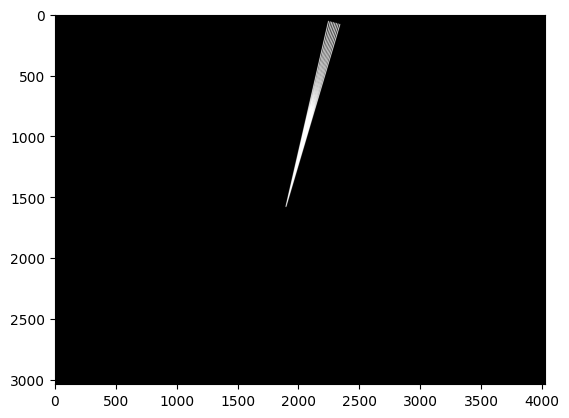

In [404]:
show(result)

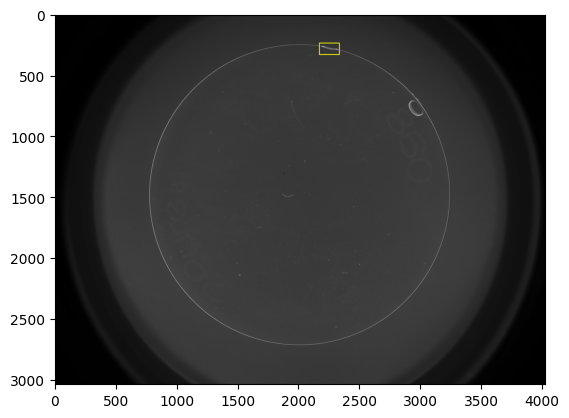

In [407]:
show(result)
diff = cv2.bitwise_and(mask, result, mask = None)
x,y,w,h = cv2.boundingRect(diff)
offset = 25
img_copy =img.copy()
cv2.rectangle(img_copy,(x-offset,y - offset), (x+w+ 2*offset, y+h +2*offset), (255,255,0), 6)
show(img_copy)

### Region Difference

##### Optimization SelectShapeStd

In [208]:
t0 = time.time()
matrix = np.empty((3000, 4000), dtype=np.float64)
t1 =time.time()
print((t1-t0)*1000)
matrix

0.0


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [408]:

@numba.njit(parallel=True)
def update_matrix(matrix, index):
    for i in numba.prange(matrix.shape[0]):
        for j in numba.prange(matrix.shape[1]):
            if labels[i, j] == index:
                matrix[i, j] = 255

@timer
@numba.jit(parallel = True)
def SelectShapeStd(Region, mode = "area"):
        numLabels, labels, stats, _ = cv2.connectedComponentsWithStats(Region, 8, cv2.CV_32S)
        h, w = Region.shape

        SelectedRegion  = np.empty((h, w) , dtype=np.uint8)
        
        if numLabels <= 1:
            return SelectedRegion, 0

        if mode == "area":
            features = list(stats[1:,4])
            
        elif mode == "width":
            features = list(stats[1:,2])   
            
        elif mode == "height":
            features = list(stats[1:,3])   
        
        max_value  = max(features)
        index = features.index(max_value) + 1
            
        print(f'Index: {index}')
        update_matrix(SelectedRegion,index )
        return SelectedRegion

C:\Users\manmu\AppData\Local\Temp\ipykernel_6012\3709552745.py:9: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(parallel = True)


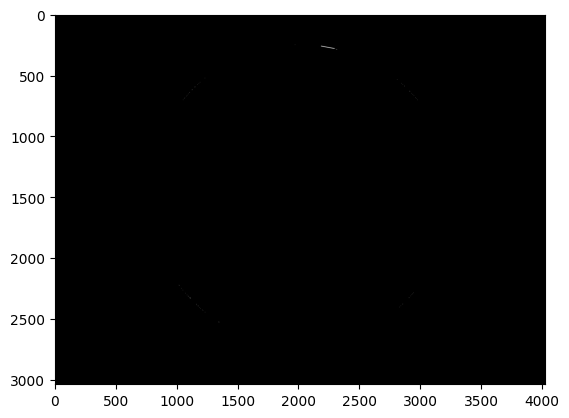

In [417]:
show(diff_opening)

In [419]:
biggest_region = SelectShapeStd(diff_opening)

Index: 2
Function SelectShapeStd took: 35.520554 (ms)


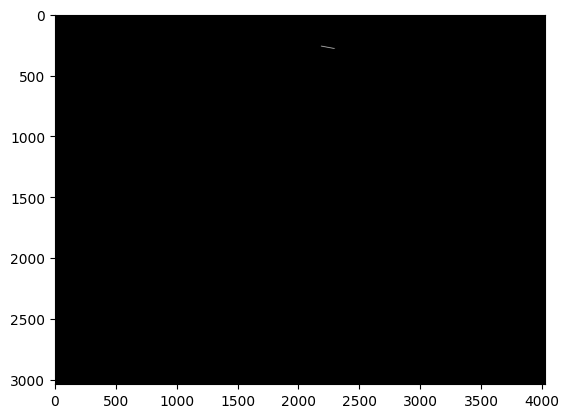

In [281]:
show(biggest_region)

#### Optimization FillUp

In [338]:
@timer
@numba.njit(parallel=True, nopython = False)
def flood_fill_optimized(region):
    region = region.astype(np.uint8)

    h, w = region.shape
    im_floodfill = np.empty((h + 2, w + 2), np.uint8)
    mask = im_floodfill.copy()

    # Add padding
    im_floodfill[1:1 + h, 1:1 + w] = region

    # Flood fill
    cv2.floodFill(im_floodfill, mask, (0, 0), 255, flags=4)
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)
    im_floodfill_inv = im_floodfill_inv[1:1 + h, 1:1 + w]

    # RegionFillUp
    region_fill_up = region | im_floodfill_inv
    return region_fill_up

Function FillUp took: 28.9989 (ms)


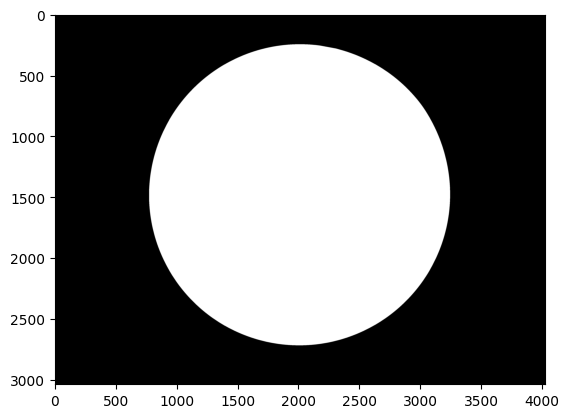

In [368]:
fillUp = Region.FillUp(mask)
show(fillUp)

### Make Sequential

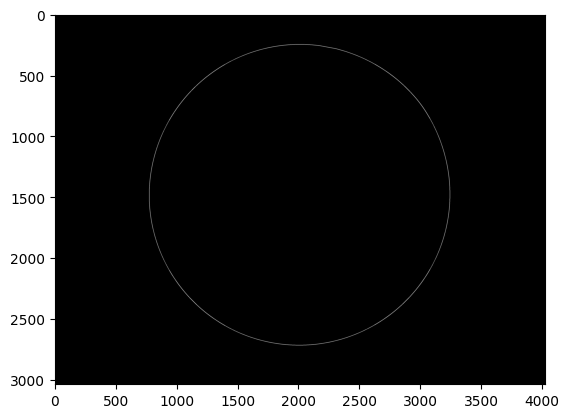

In [392]:
show(mask) # Len giả định không lỗi

Function FillUp took: 27.0092 (ms)
Function ErodeCircle took: 3.9935 (ms)
Function ErodeCircle took: 6.0008 (ms)


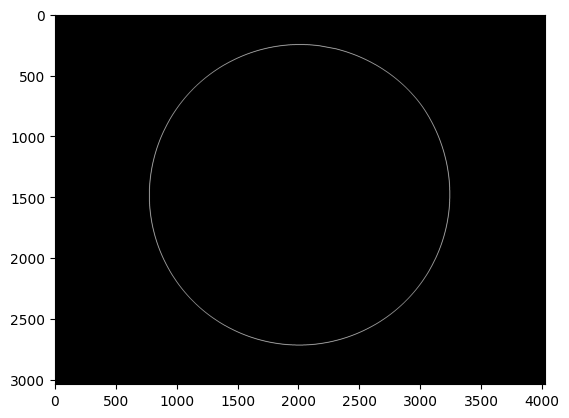

In [425]:
t0 = time.time()
# mask = Region.DrawContourMask((gray.shape[:2]),hull, thickness = 2)

fillUp  = Region.FillUp(mask)
erode_1 = Region.ErodeCircle(fillUp, 0)
erode_2 = Region.ErodeCircle(fillUp, 5)
erode_diff  = cv2.bitwise_xor(erode_1, erode_2, mask = None)

show(erode_diff)

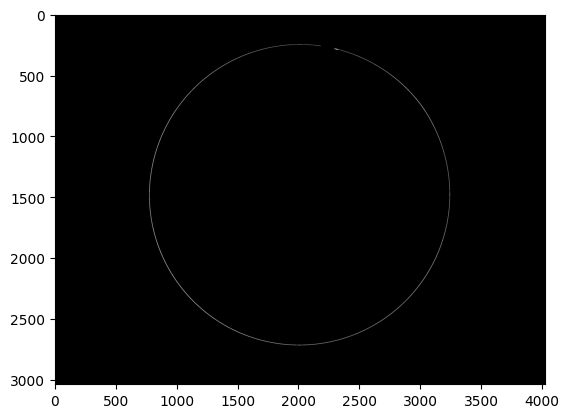

In [396]:
show(len_location)

Function OpeningCircle took: 5.9972 (ms)
index:2
Function SelectShapeStd took: 71.9984 (ms)
--------------------------------------------------
Total Time: 83.9986801147461 (ms)


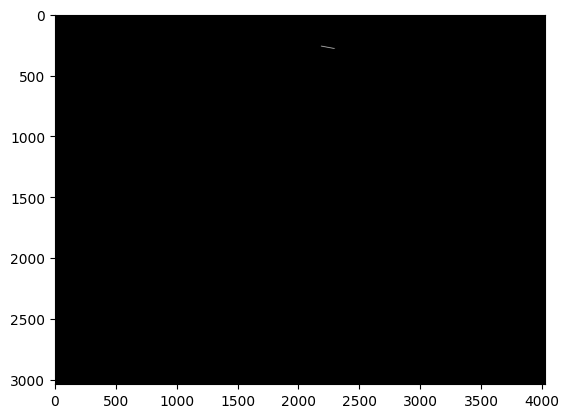

In [422]:
t0 = time.time()
diff = cv2.bitwise_xor(erode_diff, len_location, mask = None)
diff_opening = Region.OpeningCircle(diff, 1)

biggest_region = Region.SelectShapeStd(diff_opening)
t1 = time.time()

print("-"*50)
print(f"Total Time: {(t1-t0)*1000} (ms)")
show(biggest_region)

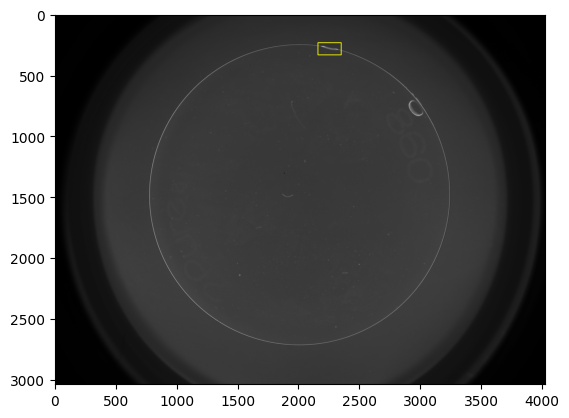

In [398]:
img_copy = img.copy()
x,y,w,h = cv2.boundingRect(biggest_region)
offset = 25 
cv2.rectangle(img_copy,(x-offset,y - offset), (x+w+ 2*offset, y+h +2*offset), (255,255,0), 6)
show(img_copy)

## Find intersection between 2 contours


In [18]:

def find_intersection_points(contour1, contour2):
    # -> smallest rectangle arround contours
    rect1 = cv2.boundingRect(contour1)
    rect2 = cv2.boundingRect(contour2)

    # -> Create ROI the both contours
    roi_x = max(rect1[0], rect2[0])
    roi_y = max(rect1[1], rect2[1])
    roi_w = min(rect1[0] + rect1[2], rect2[0] + rect2[2]) - roi_x
    roi_h = min(rect1[1] + rect1[3], rect2[1] + rect2[3]) - roi_y

    roi1 = np.zeros((roi_h, roi_w), dtype=np.uint8)
    roi2 = np.zeros((roi_h, roi_w), dtype=np.uint8)

    # Draw Contour1 and contour2 on the ROI
    cv2.drawContours(roi1, [contour1 - (roi_x, roi_y)], -1, (255), thickness=cv2.FILLED)
    cv2.drawContours(roi2, [contour2 - (roi_x, roi_y)], -1, (255), thickness=cv2.FILLED)

    # Find the intersection region
    intersection = cv2.bitwise_and(roi1, roi2)

    # Get the intersection point
    points = np.column_stack(np.where(intersection > 0))

    # -> convert point
    points[:, 0] += roi_x
    points[:, 1] += roi_y

    return points

In [19]:
len(contours)
location_contours  = contours[0]
print(location_contours.shape)

(13760, 1, 2)


In [20]:
Pline_1 = [1896,1580]
pLine_2 = [1898,20]
line_contours = np.array([[Pline_1],[pLine_2]])
line_contours.shape

(2, 1, 2)

In [21]:

list_point = find_intersection_points(location_contours,line_contours)
list_point
len(list_point)

1

In [22]:
@timer
def FindMissingEdge_Contours(threshold, center):
    R = 20
    P =(int(center[0]),R)
    step = 0.5 # Define Dregree
    # 12H -> 
    num_step = int(360 / step)
    result = np.zeros(threshold.shape[:2], dtype = np.uint8)
    contours = []
    contours.append([int(center[0]), int(center[1])])
    
    for i in range(1,num_step+1): 
        alpha = step * i
        pointRotate = rotate_point(P,center, alpha )
        
        mask = np.zeros(threshold.shape[:2], dtype = np.uint8)
        cv2.line(mask, (int(center[0]), int(center[1])),pointRotate, (255,255,255),1)

        diff = cv2.bitwise_and(mask,threshold, mask = None)
        if (np.any(diff == 255)) == False:
            contours.append(pointRotate)
            
    return contours

In [23]:
intersec_contours = FindMissingEdge_Contours(len_location, (center_x, center_y))

Function FindMissingEdge_Contours took: 10396.944046 (ms)


In [24]:
print(intersec_contours[0])
intersec_contours
len(intersec_contours)
t0 =time.time()
points = [(p[0], p[1]) for p in intersec_contours ] 
points_array = np.array(points, dtype=np.int32)

points_array = points_array.reshape((-1, 1, 2))
t1 =time.time()
print(points_array.shape)

[1896, 1580]
(10, 1, 2)


In [25]:
line_region = np.zeros((gray.shape[0], gray.shape[1]), dtype = np.uint8)
cv2.drawContours(line_region,[points_array], -1,  (255),-1)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

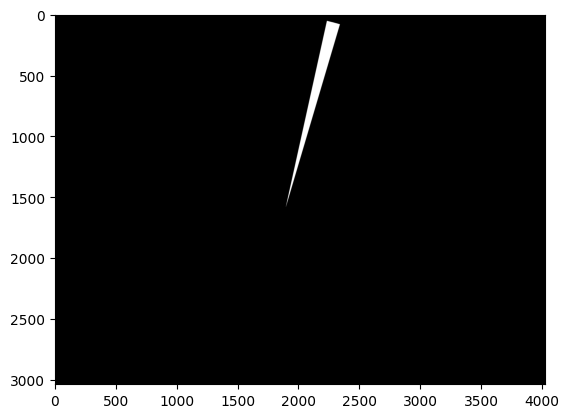

In [26]:
show(line_region)

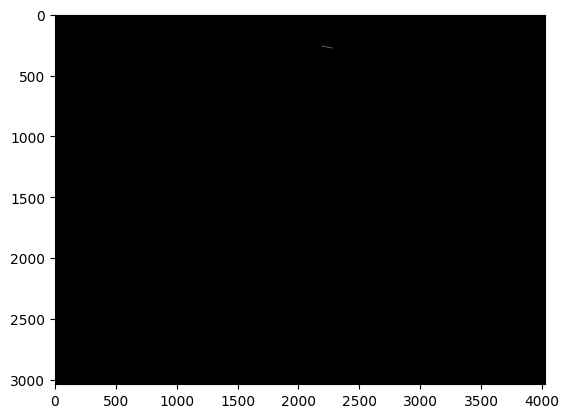

In [27]:
missing_edge = cv2.bitwise_and(mask, line_region, mask = None)
show(missing_edge)

### Draw Result

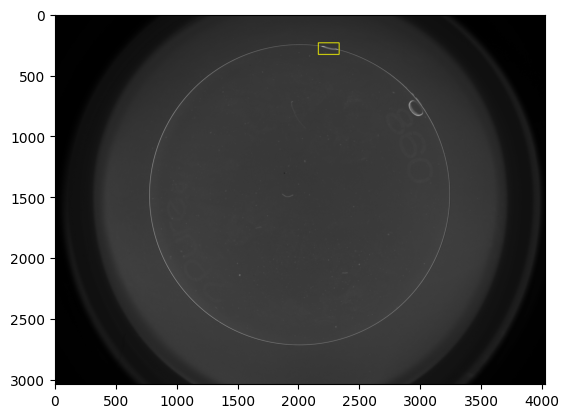

In [28]:
img_copy = img.copy()
x,y,w,h = cv2.boundingRect(missing_edge)
offset = 25 
cv2.rectangle(img_copy,(x-offset,y - offset), (x+w+ 2*offset, y+h +2*offset), (255,255,0), 6)
show(img_copy)